# properties of each water mass and how they vary

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import gsw

# for ellipse
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2, mode
from scipy.spatial.distance import mahalanobis

# for anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [4]:
def organize(s_t, do_no3, ta_dic, region, final=True):
    # make dictionary of transport and tracer concentrations of each water parcel within a specified region
    
    # the region is based on the boolean input into the function defined here
    # region options are salish, cuc, offshore deep, offshore surface, north, south, fresh, loop
    mydata= s_t
    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4
    saltdiv = 32
    sdiv = 33.5
    if region == 'salish':
        boolean = ((abs(mydata.init_t-mydata.final_t) > 24) & ~np.isnan(mydata.final_section))
    elif region == 'cuc':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv)
    elif region == 'offshore deep':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth > 120)
    elif region == 'offshore surface':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth <=120)
    elif region == 'north':
        boolean = (mydata.final_section==bdy_nor)
    elif region == 'south':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)
    elif region == 'fresh':
        boolean = ((mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv))
    elif region == 'loop':
        boolean = (mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24)
    else:
        print('not in the list of regions, options are: salish, cuc, offshore deep, offshore surface, north, south, fresh, loop')
    


    if final==True: # ie. looking at the water parcels at the outer boundaries
        # get data
        transport = mydata.init_transp[boolean].values
        salt = mydata.init_salt[boolean].values
        temp = mydata.init_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.init_salt[boolean].values
        DO = mydata.init_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.init_salt[boolean].values
        TA = mydata.init_temp[boolean].values
    else: # ie. looking at the water parcels at the JdF boundary
        # get data
        transport = mydata.final_transp[boolean].values
        salt = mydata.final_salt[boolean].values
        temp = mydata.final_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.final_salt[boolean].values
        DO = mydata.final_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.final_salt[boolean].values
        TA = mydata.final_temp[boolean].values

    # set up dictionary
    d = {'transport':transport,'salt':salt,'temp':temp,'DO':DO,'NO3':NO3,'TA':TA,'DIC':DIC}
    df = pd.DataFrame(d)

    return df

def interannual(region, property, updown):
    if updown == 'up':
        files = [up14, up15, up16, up17, up18, up19, up20, up21, up22, up23]
    elif updown == 'down':
        files = [dw13, dw14, dw15, dw16, dw17, dw18, dw19, dw20, dw21, dw22]
    elif updown == 'both':
        files = [dw13, up14, dw14, up15, dw15, up16, dw16, up17, dw17, up18, dw18, up19, dw19, up20, dw20, up21, dw21, up22, dw22, up23]
    elif updown == 'all':
        files = [co14,co15,co16,co17,co18,co19,co20,co21,co22,co23]

    data = np.zeros(len(files))
    i = 0
    for file in files:
        if property == '[TA-DIC]':
            data[i] = file['TA'][file.regions == region]-file['DIC'][file.regions == region]
        # if property == 'density': # what was i thinking here?

        else:
            data[i] = file[property][file.regions == region]
        i+=1

    return data

#####################
# BOX PLOT FUNCTION #
#####################
def box(regions,property,updown,ax,**kwargs):
    tracer = [interannual(region, property, updown) for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ax.set_xticks([])

    return bplot
        

## interannual variability

In [5]:
up14 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2018.csv')
up19 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2019.csv')
up20 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2020.csv')
up21 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2022.csv')
up23 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/up_2023.csv')

dw13 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2014.csv')
dw14 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2015.csv')
dw15 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2018.csv')
dw18 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2019.csv')
dw19 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2020.csv')
dw20 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2022.csv')
dw22 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/down_2023.csv')

co14 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2014.csv')
co15 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2015.csv')
co16 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2016.csv')
co17 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2017.csv')
co18 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2018.csv')
co19 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2019.csv')
co20 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2020.csv')
co21 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2021.csv')
co22 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2022.csv')
co23 = pd.read_csv('/ocean/rbeutel/MOAD/biogeo_paper/FRDR/model/ariane/summary_files/combo_2023.csv')

In [6]:
allyears = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
properties = ['salt','temp','DO','NO3','[TA-DIC]']

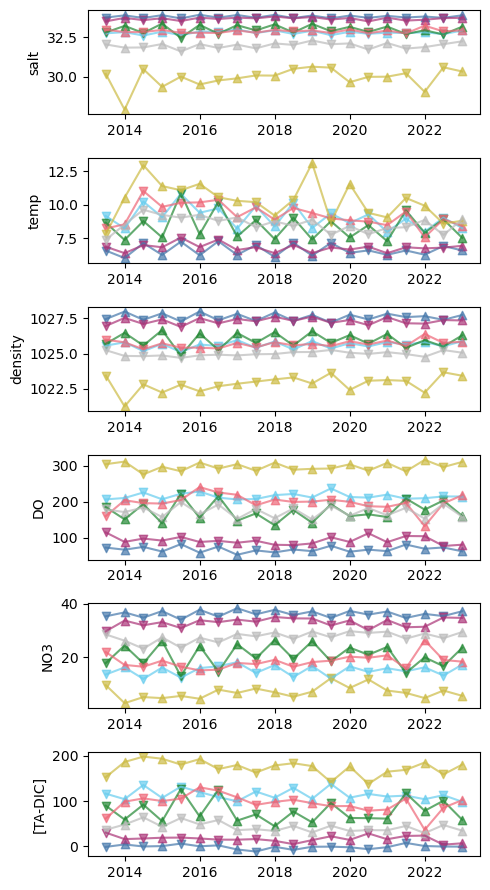

In [7]:
updownyears = np.sort(np.append(np.array(allyears),(np.array(allyears) - 0.5)))
properties = ['salt','temp','density','DO','NO3','[TA-DIC]']

fig, ax = plt.subplots(6,1,figsize=(5,9))

for i in range(len(ax)):
    ax[i].scatter(allyears, interannual('cuc', properties[i], 'up'),c='#4477AA',alpha=0.7,marker='^')
    ax[i].scatter(allyears, interannual('offshore deep', properties[i], 'up'),c='#AA3377',alpha=0.7,marker='^')
    ax[i].scatter(allyears, interannual('offshore surface', properties[i], 'up'),c='#66CCEE',alpha=0.7,marker='^')
    ax[i].scatter(allyears, interannual('north', properties[i], 'up'),c='#228833',alpha=0.7,marker='^')
    ax[i].scatter(allyears, interannual('south', properties[i], 'up'),c='#EE6677',alpha=0.7,marker='^')
    ax[i].scatter(allyears, interannual('fresh', properties[i], 'up'),c='#CCBB44',alpha=0.7,marker='^')
    ax[i].scatter(allyears, interannual('loop', properties[i], 'up'),c='#BBBBBB',alpha=0.7,marker='^')

    ax[i].scatter(np.array(allyears) - 0.5, interannual('cuc', properties[i], 'down'),c='#4477AA',alpha=0.7,marker='v')
    ax[i].scatter(np.array(allyears) - 0.5, interannual('offshore deep', properties[i], 'down'),c='#AA3377',alpha=0.7,marker='v')
    ax[i].scatter(np.array(allyears) - 0.5, interannual('offshore surface', properties[i], 'down'),c='#66CCEE',alpha=0.7,marker='v')
    ax[i].scatter(np.array(allyears) - 0.5, interannual('north', properties[i], 'down'),c='#228833',alpha=0.7,marker='v')
    ax[i].scatter(np.array(allyears) - 0.5, interannual('south', properties[i], 'down'),c='#EE6677',alpha=0.7,marker='v')
    ax[i].scatter(np.array(allyears) - 0.5, interannual('fresh', properties[i], 'down'),c='#CCBB44',alpha=0.7,marker='v')
    ax[i].scatter(np.array(allyears) - 0.5, interannual('loop', properties[i], 'down'),c='#BBBBBB',alpha=0.7,marker='v')

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='#4477AA',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='#AA3377',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='#66CCEE',alpha=0.7)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='#228833',alpha=0.7)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='#EE6677',alpha=0.7)
    ax[i].plot(updownyears, interannual('fresh', properties[i], 'both'),c='#CCBB44',alpha=0.7)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='#BBBBBB',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

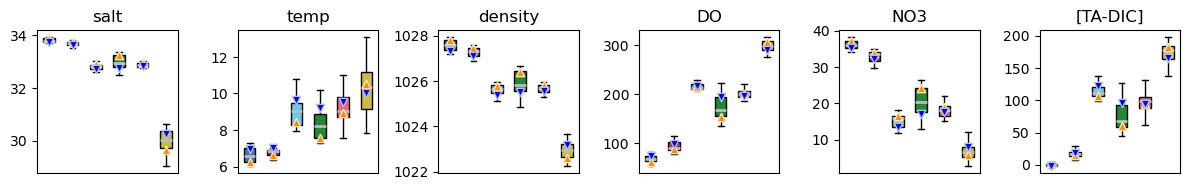

In [8]:
# box plots of the same data
# first using all the already averaged information
colours = ['#4477AA', '#AA3377', '#66CCEE', '#228833', '#EE6677','#CCBB44']
fig,ax = plt.subplots(1,6,figsize=(12,2))

regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'fresh']
for i in range(len(ax)):
    bplot = box(regions,properties[i],'both',ax[i],alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('#BBBBBB')
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax[i].scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='darkorange',edgecolors='moccasin',zorder=4)
    ax[i].scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='blue',edgecolors='lightsteelblue',zorder=4)
    ax[i].set_title(properties[i])


    # add upwelling and downwelling means

plt.tight_layout()

In [9]:
# correlation between density and salinity to see if it makes sense to keep density in this figure or not

from scipy.stats import pearsonr
print(pearsonr(interannual('cuc', 'salt', 'both'),interannual('cuc', 'density', 'both')))
print(pearsonr(interannual('offshore deep', 'salt', 'both'),interannual('offshore deep', 'density', 'both')))
print(pearsonr(interannual('offshore surface', 'salt', 'both'),interannual('offshore surface', 'density', 'both')))
print(pearsonr(interannual('north', 'salt', 'both'),interannual('north', 'density', 'both')))
print(pearsonr(interannual('south', 'salt', 'both'),interannual('south', 'density', 'both')))
print(pearsonr(interannual('fresh', 'salt', 'both'),interannual('fresh', 'density', 'both')))


PearsonRResult(statistic=np.float64(0.9592572667461189), pvalue=np.float64(2.5336621473585507e-11))
PearsonRResult(statistic=np.float64(0.9484125389737226), pvalue=np.float64(2.0366030201257772e-10))
PearsonRResult(statistic=np.float64(0.8862981310374053), pvalue=np.float64(1.983073438318647e-07))
PearsonRResult(statistic=np.float64(0.9883544338223755), pvalue=np.float64(3.5870598512570725e-16))
PearsonRResult(statistic=np.float64(0.8770492476167409), pvalue=np.float64(3.8708228292925747e-07))
PearsonRResult(statistic=np.float64(0.9060202117964662), pvalue=np.float64(3.8456228903130646e-08))


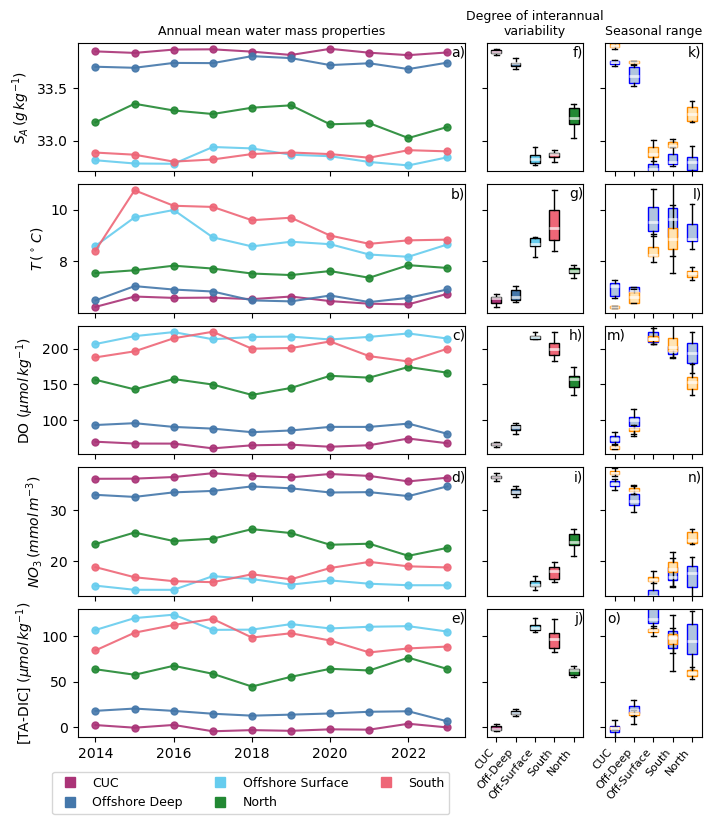

In [10]:
updownyears = np.sort(np.append(np.array(allyears)+0.5,(np.array(allyears))))
properties = ['salt','temp','DO','NO3','[TA-DIC]']
prop_names = ['$S_A \,(g\, kg^{-1})$','$T \,(^\circ \, C)$','DO $(\mu mol \, kg^{-1})$','$NO_3 \, (mmol\,m^{-3})$','[TA-DIC] $(\mu mol \, kg^{-1})$']

fig = plt.figure(constrained_layout=True, figsize=[7,2*4])
gs = GridSpec(5, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
axa = fig.add_subplot(gs[0, 5])

ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
axb = fig.add_subplot(gs[1, 5])

ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
axc = fig.add_subplot(gs[2, 5])

ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
axd = fig.add_subplot(gs[3, 5])

ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])
axe = fig.add_subplot(gs[4, 5])

# TIMESERIES
i=0
for ax in [ax1,ax3,ax5,ax7,ax9]:

    ax.plot(allyears, interannual('cuc', properties[i], 'all'),c='#AA3377',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('offshore deep', properties[i], 'all'),c='#4477AA',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('offshore surface', properties[i], 'all'),c='#66CCEE',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('north', properties[i], 'all'),c='#228833',marker='o',markersize=5,alpha=0.9)
    ax.plot(allyears, interannual('south', properties[i], 'all'),c='#EE6677',marker='o',markersize=5,alpha=0.9)
    # ax.plot(allyears, interannual('loop', properties[i], 'all'),c='#BBBBBB',marker='o',markersize=5,alpha=0.9)

    ax.set_xticks(allyears[::2])
    ax.set_xticklabels([])
    ax.set_ylabel(prop_names[i])
    i+=1

ax9.set_xticklabels(allyears[::2])

# BOXPLOTS
colours = ['#AA3377', '#4477AA', '#66CCEE', '#EE6677', '#228833', ]
regions = ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']
i=0
for ax in [ax2,ax4,ax6,ax8,ax10]:
    bplot = box(regions,properties[i],'all',ax,alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)

    ax.set_yticks([])
    i+=1
ax10.set_xticks(np.arange(1,len(regions)+1))
ax10.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'South',  'North'],rotation=50,ha='right',fontsize=8)

i=0
for ax in [axa,axb,axc,axd,axe]:
    bplot_dw = box(regions,properties[i],'down',ax,alpha=0.5)
    bplot_up = box(regions,properties[i],'up',ax,alpha=0.5)

    for patch in bplot_up['boxes']:
        patch.set_facecolor('moccasin')
        patch.set_edgecolor('darkorange')
    for patch in bplot_dw['boxes']:
        patch.set_facecolor('lightsteelblue')
        patch.set_edgecolor('blue')
    for median in bplot_up['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)
    for median in bplot_dw['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)

    ax.set_yticks([])
    ax.set_xticks(np.arange(1,len(regions)+1))
    ax.set_xticklabels([])
    i+=1
axe.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'South', 'North'],rotation=50,ha='right',fontsize=8)

# ensure that the box plots share the same yaxis as the timeseries plots
ax2.sharey(ax1)
ax2.tick_params(axis='y', which='both', labelleft=False)
ax4.sharey(ax3)
ax4.tick_params(axis='y', which='both', labelleft=False)
ax6.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax8.sharey(ax7)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax10.sharey(ax9)
ax10.tick_params(axis='y', which='both', labelleft=False)
axa.sharey(ax1)
axa.tick_params(axis='y', which='both', labelleft=False)
axb.sharey(ax3)
axb.tick_params(axis='y', which='both', labelleft=False)
axc.sharey(ax5)
axc.tick_params(axis='y', which='both', labelleft=False)
axd.sharey(ax7)
axd.tick_params(axis='y', which='both', labelleft=False)
axe.sharey(ax9)
axe.tick_params(axis='y', which='both', labelleft=False)


# # build legend handles    
legend_handles = []
regionnames = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South']
colours = ['#AA3377','#4477AA','#66CCEE','#228833','#EE6677']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regionnames[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.35, 0.05), frameon=True,fontsize=9)

ax1.set_title('Annual mean water mass properties',fontsize=9)
ax2.set_title('Degree of interannual\nvariability',fontsize=9)
axa.set_title('Seasonal range',fontsize=9)


# add text to each figure
ax1.text(1,.98,'a)', ha='right', va='top', transform=ax1.transAxes,fontsize=10)
ax2.text(1,.98,'f)', ha='right', va='top', transform=ax2.transAxes,fontsize=10)
axa.text(1,.98,'k)', ha='right', va='top', transform=axa.transAxes,fontsize=10)

ax3.text(1,.98,'b)', ha='right', va='top', transform=ax3.transAxes,fontsize=10)
ax4.text(1,.98,'g)', ha='right', va='top', transform=ax4.transAxes,fontsize=10)
axb.text(1,.98,'l)', ha='right', va='top', transform=axb.transAxes,fontsize=10)

ax5.text(1,.98,'c)', ha='right', va='top', transform=ax5.transAxes,fontsize=10)
ax6.text(1,.98,'h)', ha='right', va='top', transform=ax6.transAxes,fontsize=10)
axc.text(0.02,.98,'m)', ha='left', va='top', transform=axc.transAxes,fontsize=10)

ax7.text(1,.98,'d)', ha='right', va='top', transform=ax7.transAxes,fontsize=10)
ax8.text(1,.98,'i)', ha='right', va='top', transform=ax8.transAxes,fontsize=10)
axd.text(1,.98,'n)', ha='right', va='top', transform=axd.transAxes,fontsize=10)

ax9.text(1,.98,'e)', ha='right', va='top', transform=ax9.transAxes,fontsize=10)
ax10.text(1,.98,'j)', ha='right', va='top', transform=ax10.transAxes,fontsize=10)
axe.text(0.02,.98,'o)', ha='left', va='top', transform=axe.transAxes,fontsize=10)

plt.savefig("/ocean/rbeutel/MOAD/biogeo_paper/PI_BIOGEO_PAPER/model/figures/modelpropvar.pdf", bbox_inches='tight')

In [12]:
# statistics of combined periods
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'both'),
         'offshore deep': interannual('offshore deep', prop, 'both'),
         'offshore surface': interannual('offshore surface', prop, 'both'),
         'north': interannual('north', prop, 'both'),
         'south': interannual('south', prop, 'both'),
         'loop': interannual('loop', prop, 'both'),
         'fresh': interannual('fresh', prop, 'both')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -3.8821    True   8.447731
1                cuc              loop   -1.8359    True  12.963691
2                cuc             north   -0.8174    True   4.081786
3                cuc     offshore deep   -0.1368   False   1.516836
4                cuc  offshore surface   -1.0142    True  10.276317
5                cuc             south   -0.9263    True   8.896983
6              fresh              loop    2.0461    True  -4.324937
7              fresh             north    3.0647    True  -6.205970
8              fresh     offshore deep    3.7453    True  -8.136259
9              fresh  offshore surface    2.8679    True  -6.206686
10             fresh             south    2.9558    True  -6.380471
11              loop             north    1.0186    True  -4.43

In [13]:
# statistics of upwelling
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'up'),
         'offshore deep': interannual('offshore deep', prop, 'up'),
         'offshore surface': interannual('offshore surface', prop, 'up'),
         'north': interannual('north', prop, 'up'),
         'south': interannual('south', prop, 'up'),
         'loop': interannual('loop', prop, 'up'),
         'fresh': interannual('fresh', prop, 'up')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -4.2623    True   7.823969
1                cuc              loop   -1.8141    True  17.650334
2                cuc             north   -0.6636    True   7.337954
3                cuc     offshore deep   -0.1528   False   3.434066
4                cuc  offshore surface   -1.0107    True  19.629195
5                cuc             south   -0.9366    True  10.757573
6              fresh              loop    2.4482    True  -4.424049
7              fresh             north    3.5987    True  -6.528460
8              fresh     offshore deep    4.1095    True  -7.532416
9              fresh  offshore surface    3.2516    True  -5.953287
10             fresh             south    3.3257    True  -6.039186
11              loop             north    1.1505    True  -8.66

In [14]:
# statistics of downwelling
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'down'),
         'offshore deep': interannual('offshore deep', prop, 'down'),
         'offshore surface': interannual('offshore surface', prop, 'down'),
         'north': interannual('north', prop, 'down'),
         'south': interannual('south', prop, 'down'),
         'loop': interannual('loop', prop, 'down'),
         'fresh': interannual('fresh', prop, 'down')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -3.5018    True  17.161765
1                cuc              loop   -1.8578    True  16.140729
2                cuc             north   -0.9711    True  10.328172
3                cuc     offshore deep   -0.1207   False   2.009234
4                cuc  offshore surface   -1.0177    True  18.133725
5                cuc             south   -0.9160    True  17.048992
6              fresh              loop    1.6440    True  -7.044070
7              fresh             north    2.5307    True -11.310243
8              fresh     offshore deep    3.3811    True -15.967829
9              fresh  offshore surface    2.4842    True -11.792873
10             fresh             south    2.5859    True -12.312262
11              loop             north    0.8867    True  -6.02

In [15]:
# salt
property = 'salt'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


salt
cuc
UP: mean =33.90180105325061, std =0.031570397421275494, CV = 0.0009312306851098233
DOWN: mean =33.742329939150835, std =0.01925783105913458, CV = 0.0005707321069369884
UP & DOWN: mean =33.82206549620072, std =0.08391386109145195, CV = 0.0024810389271133692


offshore deep
UP: mean =33.74899749163611, std =0.05066737181205116, CV = 0.0015013000556418857
DOWN: mean =33.62158210610325, std =0.07829421849317163, CV = 0.0023286892998101677
UP & DOWN: mean =33.685289798869675, std =0.0916910776767344, CV = 0.002721991653454949


offshore surface
UP: mean =32.8911234277561, std =0.06144287080432874, CV = 0.0018680684756568226
DOWN: mean =32.72466233562168, std =0.07278864636623576, CV = 0.002224274940401856
UP & DOWN: mean =32.80789288168889, std =0.10707021296746885, CV = 0.003263550431403294


south
UP: mean =32.965180721877076, std =0.11246436018470903, CV = 0.0034116106061591513
DOWN: mean =32.82637115472727, std =0.06945956567366937, CV = 0.0021159684494600805
UP & DOWN: mean =3

In [16]:
# temp
property = 'temp'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


temp
cuc
UP: mean =6.259874243842211, std =0.14705393953537493, CV = 0.023491516571603772
DOWN: mean =6.963554962353487, std =0.26728145496379985, CV = 0.03838290304431893
UP & DOWN: mean =6.611714603097849, std =0.4127029889052857, CV = 0.06241996421199397


offshore deep
UP: mean =6.616533837230229, std =0.20584802893497509, CV = 0.031111157896102574
DOWN: mean =6.993844204147978, std =0.2521137365087213, CV = 0.036047948617327685
UP & DOWN: mean =6.805189020689103, std =0.29758721716885456, CV = 0.04372945648741443


offshore surface
UP: mean =8.44081948966184, std =0.4415623867425109, CV = 0.05231273898030024
DOWN: mean =9.660364021721131, std =0.5775201994575896, CV = 0.05978244693047252
UP & DOWN: mean =9.050591755691487, std =0.797543527026938, CV = 0.08812059460370653


south
UP: mean =8.920013616293941, std =0.7139871821961457, CV = 0.08004328389050047
DOWN: mean =9.5458739187494, std =0.8026571640001567, CV = 0.08408419918721412
UP & DOWN: mean =9.232943767521673, std =0.8215

In [17]:
# DO
property = 'DO'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


DO
cuc
UP: mean =62.26294479785297, std =4.330244411524532, CV = 0.06954769687786841
DOWN: mean =74.11431934265603, std =5.628583084771944, CV = 0.07594461009280899
UP & DOWN: mean =68.1886320702545, std =7.767222911257389, CV = 0.11390788574926752


offshore deep
UP: mean =88.59546762660214, std =6.410299272530984, CV = 0.0723547089287691
DOWN: mean =97.83605936545464, std =11.926900679239026, CV = 0.12190700194380832
UP & DOWN: mean =93.21576349602842, std =10.631019810392555, CV = 0.11404744660859324


offshore surface
UP: mean =214.56251958578895, std =6.39342225264376, CV = 0.029797479377974334
DOWN: mean =217.29023315155123, std =9.299421588040342, CV = 0.04279723691747511
UP & DOWN: mean =215.9263763686701, std =8.095532737909622, CV = 0.03749209741790603


south
UP: mean =200.76387215467196, std =26.892034653985192, CV = 0.13394857533564158
DOWN: mean =196.77624368225477, std =15.644992236891229, CV = 0.07950650924180687
UP & DOWN: mean =198.77005791846335, std =22.089566545549

In [18]:
# NO3
property = 'NO3'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


NO3
cuc
UP: mean =37.274649850850615, std =0.5496543266338779, CV = 0.014746062775458499
DOWN: mean =35.175854974763894, std =0.6073500905656434, CV = 0.01726610741946067
UP & DOWN: mean =36.22525241280725, std =1.1986375551519657, CV = 0.03308845281442935


offshore deep
UP: mean =33.79437810110643, std =0.9610393649998391, CV = 0.028437847328469542
DOWN: mean =32.141572223778574, std =1.6732761346068834, CV = 0.0520595608378168
UP & DOWN: mean =32.96797516244251, std =1.5952011343070516, CV = 0.04838638486127965


offshore surface
UP: mean =16.54439576357002, std =0.67404805171861, CV = 0.040741775121387755
DOWN: mean =13.468247863391198, std =1.4029566328592065, CV = 0.10416771706976538
UP & DOWN: mean =15.00632181348061, std =1.8912920241988784, CV = 0.12603301779786413


south
UP: mean =19.094952795376322, std =2.8243063401566624, CV = 0.14790852695066853
DOWN: mean =17.67000681627757, std =1.9758148847770254, CV = 0.11181743761167705
UP & DOWN: mean =18.382479805826947, std =2.53

In [19]:
# TA-DIC
property = '[TA-DIC]'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


[TA-DIC]
cuc
UP: mean =-0.7565989228966373, std =2.6295021080328462, CV = -3.47542407008168
DOWN: mean =-1.2224859215805737, std =5.63571988855045, CV = -4.610048908591052
UP & DOWN: mean =-0.9895424222386054, std =4.403643113725478, CV = -4.450181229990401


offshore deep
UP: mean =15.386482149811673, std =4.204436373805164, CV = 0.2732552075821064
DOWN: mean =18.028756051113486, std =8.345294173809789, CV = 0.46288796354834305
UP & DOWN: mean =16.70761910046258, std =6.738398391070012, CV = 0.40331290476232173


offshore surface
UP: mean =106.4177512702558, std =5.660370214670278, CV = 0.053190094200499936
DOWN: mean =122.28477772406026, std =10.088004383132308, CV = 0.08249599476638238
UP & DOWN: mean =114.35126449715804, std =11.394930619448466, CV = 0.09964848809985537


south
UP: mean =94.07757059466348, std =22.778028738432436, CV = 0.24211965290401016
DOWN: mean =94.96787547468762, std =16.483001989279842, CV = 0.1735639752589091
UP & DOWN: mean =94.52272303467555, std =19.8862